In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from pathlib import Path

In [18]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv("data/example-screen-counts.csv")
df = df.drop(["Unnamed: 0"], axis=1)

In [4]:
df.head()

,sequence,input_count,rep1_count,rep2_count
0,CDNRVESEC,1,360,329
1,CGNNVWDLC,1,320,359
2,CCNDVNCQC,0,358,278
3,CCNGVWCEC,0,306,276
4,CGNHVMDPC,1,276,240


In [5]:
df.dtypes

sequence       object
input_count     int64
rep1_count      int64
rep2_count      int64
dtype: object

In [6]:
df.describe()

,input_count,rep1_count,rep2_count
count,4.524463e+07,4.524463e+07,4.524463e+07
mean,2.802494e+00,4.139271e+00,4.250004e+00
std,4.988560e+00,7.954480e+00,8.140714e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,1.000000e+00,1.000000e+00
75%,4.000000e+00,5.000000e+00,5.000000e+00
max,1.740000e+02,8.465000e+03,8.319000e+03


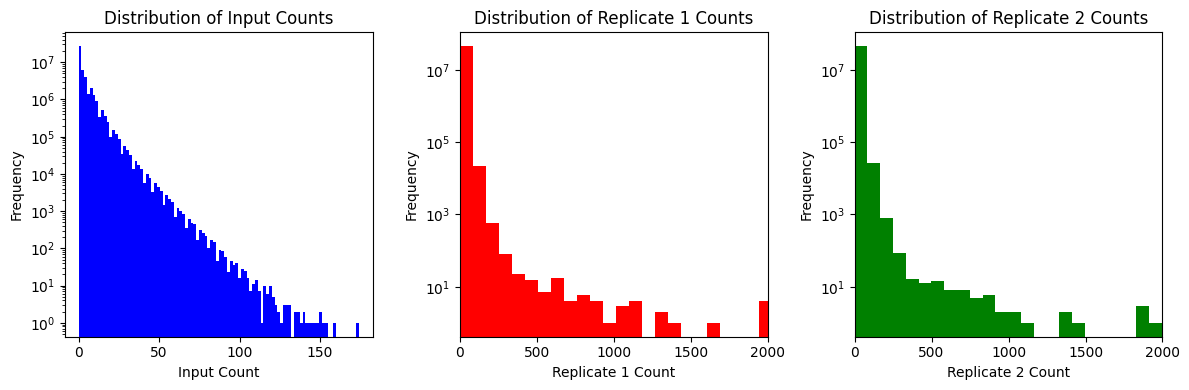

In [7]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot the input_count histogram
axs[0].hist(df["input_count"], color='blue', bins=100)
axs[0].set_xlabel("Input Count")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Distribution of Input Counts")

# Plot the rep1_count histogram
axs[1].hist(df["rep1_count"], color='red', bins=100)
axs[1].set_xlabel("Replicate 1 Count")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Distribution of Replicate 1 Counts")
axs[1].set_xlim(0,2000)

# Plot the rep1_count histogram
axs[2].hist(df["rep2_count"], color='green', bins=100)
axs[2].set_xlabel("Replicate 2 Count")
axs[2].set_ylabel("Frequency")
axs[2].set_title("Distribution of Replicate 2 Counts")
axs[2].set_xlim(0,2000)

# Set y-axis scale to logarithmic
for ax in axs:
    ax.set_yscale('log')

# Display the plots and close the figure
plt.tight_layout()
plt.savefig(Path("figures/Input_Counts_Distribution.png"), dpi=150, facecolor='w', bbox_inches='tight')
plt.show()
plt.close()

In [8]:
#df = df.sample(1000, random_state=0)

In [9]:
# Define the pseudo-count
pseudo_count = 1

# Add the pseudo-count to all the counts
df[['input_count', 'rep1_count', 'rep2_count']] += pseudo_count

# Normalize the rep counts by the input counts for each sequence
df['rep1_normalized'] = df['rep1_count'] / df['input_count']
df['rep2_normalized'] = df['rep2_count'] / df['input_count']

# Calculate the log2 fold change for sequence
df['log2_fold_change'] = np.log2((df['rep1_normalized'] + df['rep2_normalized']) / 2)

# Calculate the normalized enrichment score  NES for each sequence
df['NES'] = df['log2_fold_change'] /  np.std(df['log2_fold_change'])

# Calculate the variation between both replicates
df['CV'] = np.abs(df['rep1_count']- df['rep2_count'])
std_cv = np.std(df['CV'])
# Normalize
df['CV'] = df['CV'] / std_cv

# Calculate VNES based on NES and scaled by CV
epsilon = 1 # small value to avoid division by zero
df['VNES'] = df['NES'] / np.maximum(epsilon, df["CV"])

cols = ["sequence", 'input_count', 'rep1_count', 'rep2_count', 'log2_fold_change','CV','NES', 'VNES']
df = df[cols] 


In [20]:
df[['log2_fold_change','CV','NES', 'VNES']].describe()

,log2_fold_change,CV,NES,VNES
count,45244632.000,45244632.000,45244632.000,45244632.000
mean,0.497,0.773,0.570,0.470
std,0.871,1.000,1.000,0.880
min,-5.170,0.000,-5.937,-5.937
25%,0.222,0.247,0.255,0.147
50%,0.585,0.247,0.672,0.672
75%,0.780,0.987,0.896,0.672
max,8.317,82.203,9.552,7.622


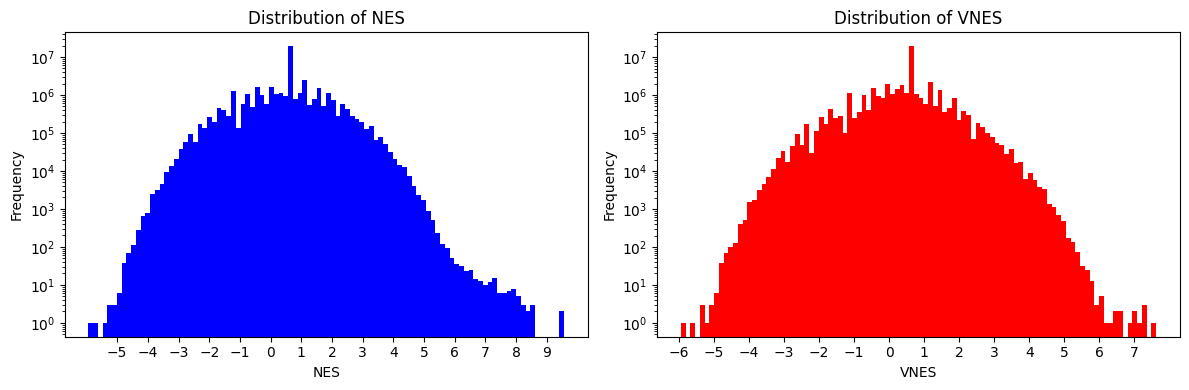

In [13]:
# Create a figure with two subplots
fig, axs = plt.subplots(1,2,figsize=(12, 4))

# Plot the NES histogram
axs[0].hist(df["NES"], color='blue', bins=100)
axs[0].set_xlabel("NES")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Distribution of NES")
axs[0].set_yscale('log')
axs[0].set_xticks(np.arange(-5,10,1))

# Plot the VNES histogram
axs[1].hist(df["VNES"], color='red', bins=100)
axs[1].set_xlabel("VNES")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Distribution of VNES")
axs[1].set_yscale('log')
axs[1].set_xticks(np.arange(-6,8,1))


# Display the plots and close the figure
plt.tight_layout()
plt.savefig(Path("figures/VNES_NES.png"), dpi=150, facecolor='w', bbox_inches='tight')
plt.show()
plt.close()

In [17]:
df.sort_values('CV', ascending=False).head(5)

,sequence,input_count,rep1_count,rep2_count,log2_fold_change,CV,NES,VNES
67,CGNSVFEEC,52,4496,4163,6.379545,82.202530,7.326624,0.089129
34,CSNSIFDEC,13,1633,1367,6.850307,65.663282,7.867274,0.119812
173,CNTGNEVWC,19,1113,871,5.706269,59.738775,6.553396,0.109701
22,CTNDIFGGC,9,1351,1131,7.107362,54.307978,8.162490,0.150300
149,CSNDIWVDC,47,2812,2594,5.845757,53.814269,6.713592,0.124755


In [15]:
df.query("VNES < -5").sort_values('VNES', ascending=False).head(5)

,sequence,input_count,rep1_count,rep2_count,log2_fold_change,CV,NES,VNES
45244617,CGSMRIGMC,31,2,1,-4.369234,0.246854,-5.017871,-5.017871
45244619,CGQRQRVKC,32,2,1,-4.415037,0.246854,-5.070475,-5.070475
45244623,CTGKIQSSC,33,2,1,-4.459432,0.246854,-5.121459,-5.121459
45244474,CQCPTGAVC,46,1,3,-4.523562,0.493709,-5.195110,-5.195110
45244627,CSDGGSALC,36,2,1,-4.584963,0.246854,-5.265626,-5.265626


In [16]:
df.query("(VNES >= -2) & (VNES <= 3)").sort_values('VNES', ascending=False).head(5)

,sequence,input_count,rep1_count,rep2_count,log2_fold_change,CV,NES,VNES
1043083,CRHMSKGVC,9,55,55,2.611435,0.000000,2.999117,2.999117
1045514,CEGSIRMRC,9,53,57,2.611435,0.987418,2.999117,2.999117
1044038,CGTLVQRCC,9,57,53,2.611435,0.987418,2.999117,2.999117
768615,CNPQNLRSC,5,30,31,2.608809,0.246854,2.996102,2.996102
768716,CWTSRTEEC,5,32,29,2.608809,0.740563,2.996102,2.996102


In [14]:
df.query("VNES > 6").sort_values('VNES', ascending=False).head(5)

,sequence,input_count,rep1_count,rep2_count,log2_fold_change,CV,NES,VNES
50,CSEVPTRRC,1,99,100,6.636625,0.246854,7.621869,7.621869
57,CCNAWWCQC,8,669,667,6.383704,0.493709,7.331401,7.331401
18,CGNEINSLC,2,161,160,6.326429,0.246854,7.265623,7.265623
87,CCDLGSYQC,1,80,76,6.285402,0.987418,7.218505,7.218505
106,CSNSVLLPC,1,75,71,6.189825,0.987418,7.108739,7.108739


In [ ]:
df.to_parquet("data/df_nes.parquet")